In [1]:
# Must be run in the DESI environment (use DESI Master kernel)

%matplotlib inline
import numpy
import pandas
from desi_specfinder import SpectrumFinder
from matplotlib import pyplot

searchdata = pandas.DataFrame( [ {'name': 'SN09alu', 'ra': 214.572816, 'dec': 53.788987 },
                                {'name': 'SN09a', 'ra': 215.982879, 'dec': 35.185546 },
                                {'name': 'SN09ac', 'ra': 186.14969, 'dec': 47.237527 } ] )

release = 'daily'
desipasswd = "5kFibers!"  # "putdespasswdhere"

# Build a SpectrumInfo object, passing it the list of ras, decs, and (optionally) names of hosts
# (I did it from a pandas dataframe, but you can just make three lists.)
# radius is the how close the target must be (in degrees) to your specified ra/dec for a match to be found
# collection is "daily" or "everest"

si = SpectrumFinder( searchdata['ra'].values, searchdata['dec'].values, names=searchdata['name'].values, radius=1./3600., collection=release, desipasswd=desipasswd )

[2022-12-05 11:09:25,452 - INFO] - Looking for daily spectra at 3 positions w/in 0.0002777777777777778°.)
[2022-12-05 11:09:25,456 - DEBUG] - Search table:
      name          ra        dec
0  SN09alu  214.572816  53.788987
1    SN09a  215.982879  35.185546
2   SN09ac  186.149690  47.237527
[2022-12-05 11:09:25,483 - DEBUG] - Filling temporary table...
[2022-12-05 11:09:25,492 - DEBUG] - ...filled.
[2022-12-05 11:09:25,493 - DEBUG] - Filling second temporary table...
[2022-12-05 11:09:25,497 - DEBUG] - ...filled


In [2]:
# You can can get the list of all targetids that matched anything by looking at the SpectrumFinder's targetids property:
print( si.targetids )

{39633304558764813, 39633204071631854}


In [3]:
# You can get the targetids (as a set) for a given object with SpectrumFinder.targetids_for_name()
# In this example, one object isn't observed.  The other two have a single targetid
# with one or more observations.  It's possible that the same object will have more
# than one targetid!  That didn't happen in this example, but it could.

for name in searchdata['name'].values:
    print( f"Targetids for {name}: {si.targetids_for_name(name)}" )

Targetids for SN09alu: {39633304558764813}
Targetids for SN09a: set()
Targetids for SN09ac: {39633204071631854}


In [6]:
# You can get information the spectra for a given targetid with SpectrumFinder.info_for_targetid:
# What you get is a list of dicts.  Notice in this example that there are *two* spectra for the
# targetid I chose, one on 2021-04-05, the other on 2021-05-06.  Happily, they give the same redshift....

tid = list( si.targetids_for_name('SN09alu') )[0]
targetinfo = si.info_for_targetid( tid )
targetinfo

[{'z': 0.0744127307916863,
  'zerr': 2.75092937715152e-05,
  'zwarn': 0,
  'deltachi2': 3268.97682878166,
  'filename': 'daily/tiles/cumulative/174/20210405/zbest-4-174-thru20210405.fits',
  'tileid': 174,
  'petal_loc': 4,
  'device_loc': 389,
  'night': 20210405},
 {'z': 0.0744554092356092,
  'zerr': 2.53984261047757e-05,
  'zwarn': 0,
  'deltachi2': 5309.30698201107,
  'filename': 'daily/tiles/cumulative/182/20210506/zbest-4-182-thru20210506.fits',
  'tileid': 182,
  'petal_loc': 4,
  'device_loc': 476,
  'night': 20210506}]

In [7]:
# this result is also easily pandas-able
targetinfodf = pandas.DataFrame( targetinfo )
targetinfodf

,z,zerr,zwarn,deltachi2,filename,tileid,petal_loc,device_loc,night
0,0.074413,0.000028,0,3268.976829,daily/tiles/cumulative/174/20210405/zbest-4-17...,174,4,389,20210405
1,0.074455,0.000025,0,5309.306982,daily/tiles/cumulative/182/20210506/zbest-4-18...,182,4,476,20210506


In [24]:
# You can get all spectra for a given targetid with SpectrumFinder.get_spectra
# (If you want just a single spectrum, use SpectrumFinder.get_spectrum( targetid, tile, petal, night )
#
# This returns a list of desispec.spectra.Spectra objects
# For information about desispec, see : https://desispec.readthedocs.io/en/latest/
#
# For these spectra, I've combined together the three channels, so there's just a
# 'brz' entry to wave, flux, and ivar

spectra = si.get_spectra( tid, smooth=4 )
spectra

INFO:spectra.py:291:read_spectra: iotime 0.397 sec to read coadd-4-174-thru20210405.fits at 2022-12-05T11:20:13.176832
INFO:spectra.py:291:read_spectra: iotime 0.398 sec to read coadd-4-182-thru20210506.fits at 2022-12-05T11:20:14.005729


Text(0, 0.5, 'flux density')

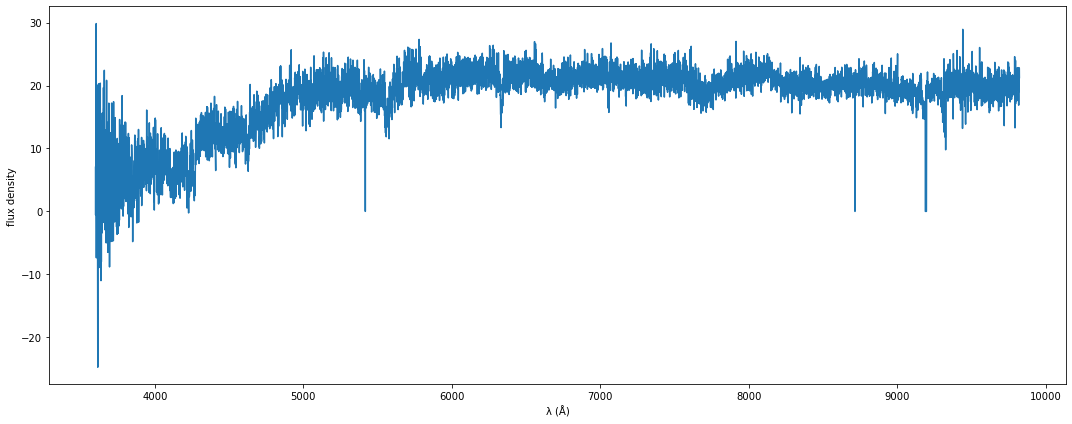

In [32]:
# Plot the second spectrum:
fig = pyplot.figure( figsize=(15,6), tight_layout=True )
ax = fig.add_subplot( 1, 1, 1 )
ax.plot( spectra[1].wave['brz'], spectra[1].flux['brz'][0, :] )
ax.set_xlabel( 'λ (Å)' )
ax.set_ylabel( 'flux density' )